In [1]:
import uproot
from pathlib import Path
import requests
from tqdm import tqdm
import numpy as np
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import json

class ATLASDataManager:
    def __init__(self, base_dir: str = "atlas_data"):
        """Initialize the data manager with a base directory."""
        self.base_dir = Path(base_dir)
        self.base_url = "https://opendata.cern.ch/record/80001/files"
        self._setup_directories()
        
    def _setup_directories(self):
        """Create necessary directory structure."""
        # Main data directory
        self.base_dir.mkdir(exist_ok=True)
        # Directory for run catalogs
        (self.base_dir / "catalogs").mkdir(exist_ok=True)
        # Directory for PHYSLITE data
        (self.base_dir / "physlite").mkdir(exist_ok=True)
        
    def _download_file(self, url: str, output_path: Path, desc: str = None) -> bool:
        """Download a single file if it doesn't exist."""
        if output_path.exists():
            return False
            
        print(f"downloading file: https://opendata.cern.ch{url}")   
        response = requests.get(f"https://opendata.cern.ch{url}", stream=True)
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            
            with open(output_path, 'wb') as f, tqdm(
                desc=desc,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as pbar:
                for data in response.iter_content(chunk_size=1024):
                    size = f.write(data)
                    pbar.update(size)
            return True
        else:
            raise Exception(f"Download failed with status code: {response.status_code}")
    
    def download_run_catalog(self, run_number: str, index: int = 0) -> bool:
        """Download a specific run catalog file."""
        url = f"/record/80001/files/data16_13TeV_Run_{run_number}_file_index.json_{index}"
        output_path = self.base_dir / "catalogs" / f"Run_{run_number}_catalog_{index}.root"
        return self._download_file(url, output_path, f"Downloading catalog {index} for Run {run_number}")
    
    def examine_catalog(self, run_number: str, index: int = 0):
        """Examine contents of a run catalog file."""
        catalog_path = self.base_dir / "catalogs" / f"Run_{run_number}_catalog_{index}.root"
        if not catalog_path.exists():
            print(f"Catalog file not found: {catalog_path}")
            return
        
        try:
            with uproot.open(catalog_path) as file:
                print(f"Contents of Run {run_number} catalog {index}:")
                for key in file.keys():
                    try:
                        obj = file[key]
                        print(f"\nObject {key}:")
                        print(f"Type: {type(obj)}")
                        print(f"Info: {obj}")
                    except Exception as e:
                        print(f"Couldn't read {key}: {str(e)}")
        except Exception as e:
            print(f"Error examining catalog: {str(e)}")
    
    def get_stats(self) -> Dict:
        """Get statistics about downloaded files."""
        stats = {
            "catalogs": len(list((self.base_dir / "catalogs").glob("*.root"))),
            "physlite_files": len(list((self.base_dir / "physlite").glob("*.root"))),
            "total_size": sum(f.stat().st_size for f in self.base_dir.rglob("*.*")) / (1024 * 1024 * 1024)  # in GB
        }
        return stats
    
    def print_status(self):
        """Print current status of downloads."""
        stats = self.get_stats()
        print(f"=== ATLAS Data Status ===")
        print(f"Number of run catalogs: {stats['catalogs']}")
        print(f"Number of PHYSLITE files: {stats['physlite_files']}")
        print(f"Total data size: {stats['total_size']:.2f} GB")

In [ ]:
def get_available_runs(self) -> Dict[str, List[int]]:
    """
    Get all available run numbers and their indices from CERN Open Data.
    
    Returns:
        Dict mapping run numbers to list of available indices
    """
    # URL for the dataset record
    record_url = "https://opendata.cern.ch/record/80001"
    
    print("Fetching available runs from CERN Open Data...")
    response = requests.get(record_url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch dataset info: {response.status_code}")
    
    # Extract file information using the pattern data16_13TeV_Run_XXXXXX_file_index.json_Y
    content = response.text
    run_indices = {}
    
    # Use regex to find all matching files
    import re
    pattern = r'data16_13TeV_Run_(\d+)_file_index\.json_?(\d*)'
    matches = re.finditer(pattern, content)
    
    for match in matches:
        run_number = match.group(1)
        index = match.group(2)
        index = int(index) if index else 0
        
        if run_number not in run_indices:
            run_indices[run_number] = []
        if index not in run_indices[run_number]:
            run_indices[run_number].append(index)
    
    # Sort indices for each run
    for run in run_indices:
        run_indices[run].sort()
    
    print(f"Found {len(run_indices)} runs:")
    for run, indices in run_indices.items():
        print(f"Run {run}: {len(indices)} indices {indices}")
    
    return run_indices


In [2]:
# Initialize manager
data_mgr = ATLASDataManager()

# Download a run catalog
data_mgr.download_run_catalog("00296939", 0)

# Examine its contents
data_mgr.examine_catalog("00296939", 0)

# Check status
data_mgr.print_status()

Contents of Run 00296939 catalog 0:

Object ##Params;3:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Params' (2 branches) at 0x7fe04a521c40>

Object ##Params;2:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Params' (2 branches) at 0x7fe04a521e20>

Object ##Shapes;3:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Shapes' (2 branches) at 0x7fe04a521340>

Object ##Shapes;2:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Shapes' (2 branches) at 0x7fe04a524e50>

Object ##Links;3:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Links' (2 branches) at 0x7fe04a525f70>

Object ##Links;2:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree '##Links' (2 branches) at 0x7fe04a51d370>

Object MetaData;1:
Type: <class 'uproot.models.TTree.Model_TTree_v20'>
Info: <TTree 'MetaData' (26 branches) at 0x7fdffa506310>

Object MetaDataHdr;1:
Type: <class 'uproot.models.TTree.Model_TTree_v2

In [3]:
def extract_metadata(catalog_path):
    """
    Extract PHYSLITE file references from a catalog ROOT file
    Returns a list of file references
    """
    try:
        with uproot.open(catalog_path) as file:
            if "MetaData;1" in file:
                metadata = file["MetaData;1"]
                print("Found MetaData tree")
                print("\nBranches:")
                for i, branch in enumerate(metadata.keys(), 1):
                    print(f"{i}. {branch}")
                
                # Let's look at a few selected branches first
                # We can add more specific branch examination based on what we find
                print("\nSample of first few entries from selected branches:")
                for i, branch in enumerate(metadata.keys(), 1):
                    try:
                        data = metadata[branch].array()
                        print(f"\n {i}.  Branch: {branch}")
                        print("Type of data:", type(data))
                        print("Data (truncated)", str(data)[:200])
                    except Exception as e:
                        print(f"\n {i}.  Couldn't read branch {branch}: {str(e)}")
                        
    except Exception as e:
        print(f"Error examining catalog: {str(e)}")

# Try it on one catalog file
catalog_path = "atlas_data/catalogs/Run_00296939_catalog_0.root"
extract_metadata(catalog_path)

Found MetaData tree

Branches:
1. FileMetaDataAux.
2. FileMetaDataAux./FileMetaDataAux.xAOD::AuxInfoBase
3. FileMetaDataAux./FileMetaDataAux.productionRelease
4. FileMetaDataAux./FileMetaDataAux.dataType
5. FileMetaDataAux./FileMetaDataAux.runNumbers
6. FileMetaDataAux./FileMetaDataAux.lumiBlocks
7. TriggerMenuJson_HLTAux.
8. TriggerMenuJson_HLTAux./TriggerMenuJson_HLTAux.xAOD::AuxContainerBase
9. TriggerMenuJson_HLTAux./TriggerMenuJson_HLTAux.key
10. TriggerMenuJson_HLTAux./TriggerMenuJson_HLTAux.name
11. TriggerMenuJson_HLTAux./TriggerMenuJson_HLTAux.payload
12. TriggerMenuJson_HLTPSAux.
13. TriggerMenuJson_HLTPSAux./TriggerMenuJson_HLTPSAux.xAOD::AuxContainerBase
14. TriggerMenuJson_HLTPSAux./TriggerMenuJson_HLTPSAux.key
15. TriggerMenuJson_HLTPSAux./TriggerMenuJson_HLTPSAux.name
16. TriggerMenuJson_HLTPSAux./TriggerMenuJson_HLTPSAux.payload
17. TriggerMenuJson_L1Aux.
18. TriggerMenuJson_L1Aux./TriggerMenuJson_L1Aux.xAOD::AuxContainerBase
19. TriggerMenuJson_L1Aux./TriggerMenuJson_L

In [4]:
def explore_collection_tree(catalog_path):
    """
    Explore the structure and contents of the CollectionTree in a ROOT file.
    
    Args:
        catalog_path (str): Path to the ROOT file
    """
    try:
        with uproot.open(catalog_path) as file:
            if "CollectionTree;1" not in file:
                print("No CollectionTree found in file")
                return
                
            tree = file["CollectionTree;1"]
            print(f"\nCollectionTree contains {len(tree)} entries")
            
            # Get all branch names
            branches = tree.keys()
            print(f"\nTotal number of branches: {len(branches)}")

            # Print all branch names enumerated
            for i, branch in enumerate(branches, 1):
                print(f"{i}. {branch}")
            
            # Group branches by type/category based on common prefixes
            branch_groups = {}
            for branch in branches:
                # Split on first dot or underscore
                prefix = branch.split('.')[0].split('_')[0]
                if prefix not in branch_groups:
                    branch_groups[prefix] = []
                branch_groups[prefix].append(branch)
            
            # Print branch groups and their sizes
            print("\nBranch groups found:")
            for prefix, group in sorted(branch_groups.items()):
                print(f"\n{prefix}: {len(group)} branches")
                # Print first few branches in each group
                for branch in sorted(group)[:5]:
                    try:
                        # Try to get the type and shape of the branch
                        array = tree[branch].array()
                        print(f"  - {branch}")
                        print(f"    Type: {type(array)}")
                        print(f"    Shape/Length: {len(array)}")
                        # Try to show a sample value from first event if possible
                        try:
                            sample = array[0]
                            print(f"    First event sample: {str(sample)[:100]}")
                        except:
                            pass
                    except Exception as e:
                        print(f"  - {branch} (Could not read: {str(e)})")
                if len(group) > 5:
                    print(f"  ... and {len(group)-5} more branches")
                    
    except Exception as e:
        print(f"Error examining CollectionTree: {str(e)}")

# Try it on the catalog file
catalog_path = "atlas_data/catalogs/Run_00296939_catalog_0.root"
explore_collection_tree(catalog_path)


CollectionTree contains 790 entries

Total number of branches: 867
1. xTrigDecisionAux.
2. xTrigDecisionAux./xTrigDecisionAux.xAOD::AuxInfoBase
3. xTrigDecisionAux./xTrigDecisionAux.smk
4. xTrigDecisionAux./xTrigDecisionAux.bgCode
5. xTrigDecisionAux./xTrigDecisionAux.tav
6. xTrigDecisionAux./xTrigDecisionAux.tap
7. xTrigDecisionAux./xTrigDecisionAux.tbp
8. xTrigDecisionAux./xTrigDecisionAux.lvl2ErrorBits
9. xTrigDecisionAux./xTrigDecisionAux.efErrorBits
10. xTrigDecisionAux./xTrigDecisionAux.lvl2Truncated
11. xTrigDecisionAux./xTrigDecisionAux.efTruncated
12. xTrigDecisionAux./xTrigDecisionAux.lvl2PassedPhysics
13. xTrigDecisionAux./xTrigDecisionAux.efPassedPhysics
14. xTrigDecisionAux./xTrigDecisionAux.lvl2PassedRaw
15. xTrigDecisionAux./xTrigDecisionAux.efPassedRaw
16. xTrigDecisionAux./xTrigDecisionAux.lvl2PassedThrough
17. xTrigDecisionAux./xTrigDecisionAux.efPassedThrough
18. xTrigDecisionAux./xTrigDecisionAux.lvl2Prescaled
19. xTrigDecisionAux./xTrigDecisionAux.efPrescaled
20. 

In [5]:
import numpy as np
def extract_track_data(file_path):
    """
    Extract track information from ATLAS PHYSLITE data.
    
    Args:
        file_path (str): Path to ROOT file
    Returns:
        dict: Dictionary containing track parameters and arrays
    """
    try:
        with uproot.open(file_path) as file:
            tree = file["CollectionTree;1"]
            
            # Track parameters we want to extract
            track_branches = [
                "InDetTrackParticlesAuxDyn.d0",
                "InDetTrackParticlesAuxDyn.z0",
                "InDetTrackParticlesAuxDyn.phi",
                "InDetTrackParticlesAuxDyn.theta",
                "InDetTrackParticlesAuxDyn.qOverP",
                "InDetTrackParticlesAuxDyn.chiSquared",
                "InDetTrackParticlesAuxDyn.numberDoF",
                "InDetTrackParticlesAuxDyn.definingParametersCovMatrixDiag"
            ]
            
            # Initialize dictionary to store track data
            track_data = {}
            
            # Read each branch using numpy arrays
            for branch in track_branches:
                try:
                    # Extract the parameter name from the branch name
                    param_name = branch.split('.')[-1]
                    track_data[param_name] = tree[branch].array(library="np")
                    
                    # Print some basic statistics
                    if len(track_data[param_name]) > 0:
                        print(f"\n{param_name}:")
                        print(f"  Number of entries: {len(track_data[param_name])}")
                        print(f"  First few values: {track_data[param_name][:5]}")
                except Exception as e:
                    print(f"Could not read branch {branch}: {str(e)}")
            
            # Calculate derived quantities
            if 'qOverP' in track_data:
                # Convert q/p to pT (transverse momentum)
                # Note: This is a simplified conversion
                track_data['pT'] = abs(1.0 / track_data['qOverP']) * np.sin(track_data['theta'])
                
            if 'chiSquared' in track_data and 'numberDoF' in track_data:
                # Calculate chi2/ndof
                track_data['chi2_per_ndof'] = track_data['chiSquared'] / track_data['numberDoF']
            
            return track_data
            
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        return None

def analyze_tracks(track_data):
    """
    Perform basic analysis on the extracted track data.
    
    Args:
        track_data (dict): Dictionary containing track parameters
    """
    if track_data is None:
        return
        
    print("\nTrack Analysis Summary:")
    
    for param, values in track_data.items():
        if len(values) > 0:
            print(f"\n{param}:")
            try:
                # Calculate basic statistics
                mean = np.mean(values)
                median = np.median(values)
                std = np.std(values)
                
                print(f"  Mean: {mean:.4f}")
                print(f"  Median: {median:.4f}")
                print(f"  Std Dev: {std:.4f}")
                # print(f"  Range: [{np.min(values):.4f}, {np.max(values):.4f}]")
            except Exception as e:
                print(f"  Could not calculate statistics: {str(e)}")

# Run the analysis
file_path = "atlas_data/catalogs/Run_00296939_catalog_0.root"
track_data = extract_track_data(file_path)
analyze_tracks(track_data)


d0:
  Number of entries: 12352
  First few values: [array([], dtype=float32) array([-0.0716477], dtype=float32)
 array([-0.04982265, -0.16506408], dtype=float32)
 array([-0.05006231, -0.03200515], dtype=float32) array([], dtype=float32)]

z0:
  Number of entries: 12352
  First few values: [array([], dtype=float32) array([66.70478], dtype=float32)
 array([34.215153, 34.318176], dtype=float32)
 array([28.545576, 28.482952], dtype=float32) array([], dtype=float32)]

phi:
  Number of entries: 12352
  First few values: [array([], dtype=float32) array([-0.15316485], dtype=float32)
 array([-0.42112437, -0.31479055], dtype=float32)
 array([-2.0316765, -1.9575816], dtype=float32) array([], dtype=float32)]

theta:
  Number of entries: 12352
  First few values: [array([], dtype=float32) array([0.34525588], dtype=float32)
 array([2.4879005, 2.5871496], dtype=float32)
 array([1.5983181, 1.5416944], dtype=float32) array([], dtype=float32)]

qOverP:
  Number of entries: 12352
  First few values: [ar

In [6]:
def analyze_pt_calculation(track_data: Dict[str, np.ndarray]) -> None:
    """
    Analyze the pT calculation to identify potential numerical issues
    """
    qOverP = track_data['qOverP']
    theta = track_data['theta']
    
    # Calculate pT
    pT = np.abs(1.0 / qOverP) * np.sin(theta)
    
    # Find extreme pT values
    high_pt_mask = pT > 1000  # Look at tracks above 1 TeV
    
    print("\nAnalyzing pT calculation:")
    print(f"Total tracks: {len(pT)}")
    print(f"Tracks with pT > 1 TeV: {np.sum(high_pt_mask)}")
    print("\nqOverP distribution for high-pT tracks:")
    print(f"  min: {np.min(np.abs(qOverP[high_pt_mask])):.2e}")
    print(f"  max: {np.max(np.abs(qOverP[high_pt_mask])):.2e}")
    
    return pT

def calculate_pt_with_units(qOverP: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Calculate pT with proper ATLAS units conversion
    qOverP: charge over momentum [MeV⁻¹]
    returns: pT [GeV]
    """
    # Convert from MeV to GeV
    qOverP_GeV = qOverP * 1000
    
    # Calculate pT
    pT_GeV = np.abs(1.0 / qOverP_GeV) * np.sin(theta)
    
    print("\nAnalyzing pT calculation with MeV conversion:")
    print(f"Total tracks: {len(pT_GeV)}")
    print(f"Tracks with pT > 100 GeV: {np.sum(pT_GeV > 100)}")
    print(f"pT range: [{np.min(pT_GeV):.2f}, {np.max(pT_GeV):.2f}] GeV")
    
    return pT_GeV

shape of arrays:  (12352,)

d0:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: -0.009260
  Std Dev: 0.666579
shape of arrays:  (12352,)

z0:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 26.116993
  Std Dev: 37.544907
shape of arrays:  (12352,)

phi:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 0.028078
  Std Dev: 1.802552
shape of arrays:  (12352,)

theta:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 1.539450
  Std Dev: 0.923782
shape of arrays:  (12352,)

qOverP:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 0.000003
  Std Dev: 0.000256
shape of arrays:  (12352,)

chiSquared:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 29.535044
  Std Dev: 14.192817
shape of arrays:  (12352,)

numberDoF:
  Total entries: 35477
  Non-zero entries: 35477
  Mean: 32.879078
  Std Dev: 12.671445

Analyzing pT calculation with MeV conversion:
Total tracks: 35477
Tracks with pT > 100 GeV: 26
pT range: [0.56, 3680.38] GeV

pT (GeV):
  Total

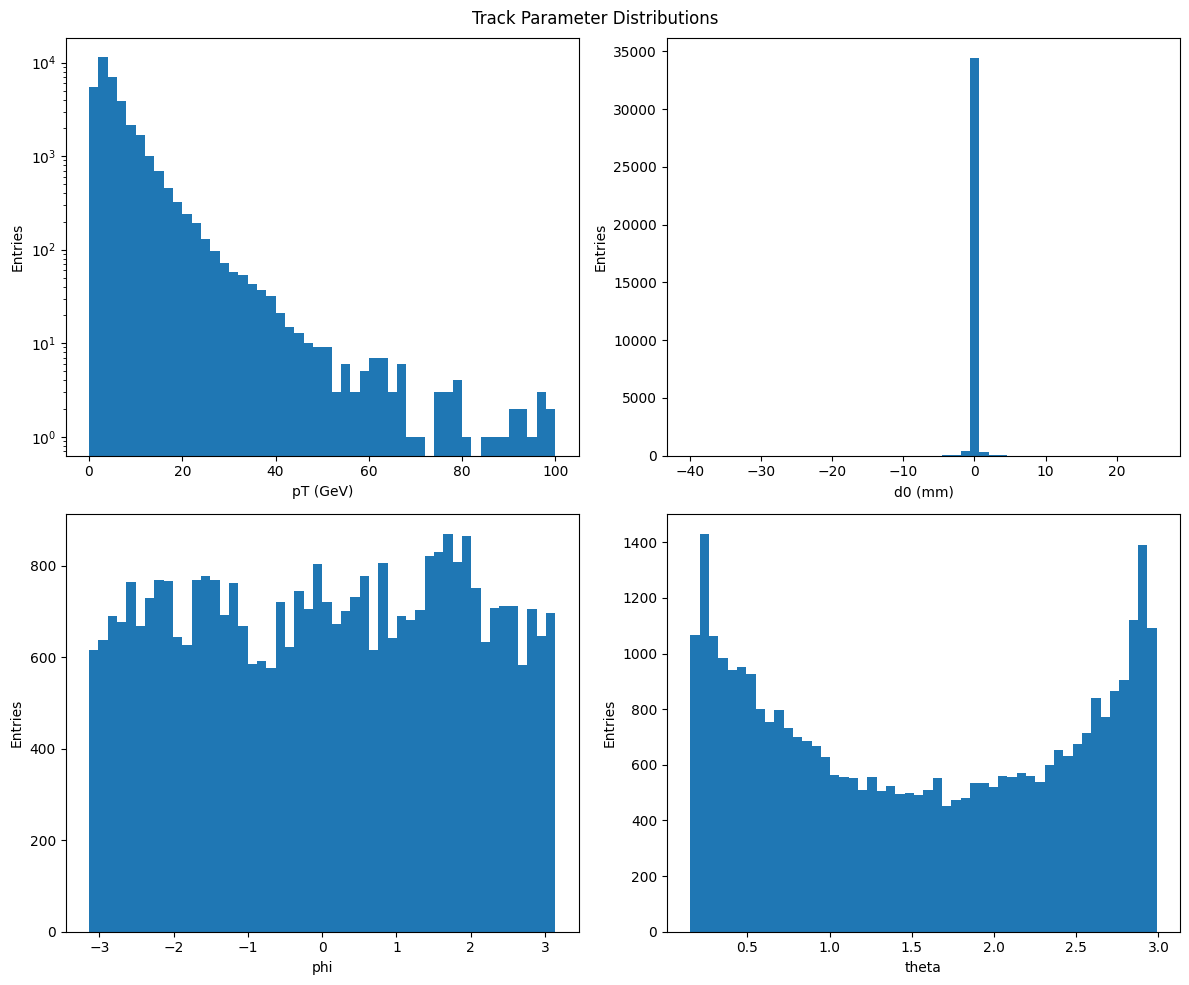

In [7]:


def flatten_and_clean_arrays(arrays: List[np.ndarray]) -> np.ndarray:
    """
    Flatten jagged arrays and remove empty arrays.
    
    Args:
        arrays: List of arrays, some of which may be empty
    Returns:
        Flattened array with non-empty values
    """
    # Filter out empty arrays and flatten
    valid_arrays = [arr for arr in arrays if len(arr) > 0]
    if not valid_arrays:
        return np.array([])
    return np.concatenate(valid_arrays)

def extract_track_data(file_path: str) -> Optional[Dict[str, np.ndarray]]:
    """
    Extract track information from ATLAS PHYSLITE data.
    
    Args:
        file_path: Path to ROOT file
    Returns:
        Dictionary containing track parameters
    """
    try:
        with uproot.open(file_path) as file:
            tree = file["CollectionTree;1"]
            
            # Track parameters to extract
            track_branches = {
                "d0": "InDetTrackParticlesAuxDyn.d0",
                "z0": "InDetTrackParticlesAuxDyn.z0",
                "phi": "InDetTrackParticlesAuxDyn.phi",
                "theta": "InDetTrackParticlesAuxDyn.theta",
                "qOverP": "InDetTrackParticlesAuxDyn.qOverP",
                "chiSquared": "InDetTrackParticlesAuxDyn.chiSquared",
                "numberDoF": "InDetTrackParticlesAuxDyn.numberDoF"
            }
            
            track_data = {}
            
            # Read and process each branch
            for param_name, branch in track_branches.items():
                try:
                    arrays = tree[branch].array(library="np")
                    print("shape of arrays: ", arrays.shape)
                    flat_data = flatten_and_clean_arrays(arrays)
                    track_data[param_name] = flat_data
                    
                    if len(flat_data) > 0:
                        print(f"\n{param_name}:")
                        print(f"  Total entries: {len(flat_data)}")
                        print(f"  Non-zero entries: {np.count_nonzero(flat_data)}")
                        print(f"  Mean: {np.mean(flat_data):.6f}")
                        print(f"  Std Dev: {np.std(flat_data):.6f}")
                        
                except Exception as e:
                    print(f"Could not process {param_name}: {str(e)}")
            
            # Calculate derived quantities
            if all(key in track_data for key in ['qOverP', 'theta']):
                pT = calculate_pt_with_units(
                    track_data['qOverP'],
                    track_data['theta']
                )
                track_data['pT'] = pT
                
                print("\npT (GeV):")
                print(f"  Total entries: {len(pT)}")
                print(f"  Mean: {np.mean(pT):.2f}")
                print(f"  Std Dev: {np.std(pT):.2f}")
                print(f"  Range: [{np.min(pT):.2f}, {np.max(pT):.2f}]")
            
            # Create visualization of track distributions
            try:
                import matplotlib.pyplot as plt
                
                fig, axes = plt.subplots(2, 2, figsize=(12, 10))
                fig.suptitle('Track Parameter Distributions')
                
                # pT distribution (log scale)
                if 'pT' in track_data:
                    axes[0,0].hist(track_data['pT'], bins=50, range=(0, 100))
                    axes[0,0].set_xlabel('pT (GeV)')
                    axes[0,0].set_ylabel('Entries')
                    axes[0,0].set_yscale('log')
                
                # d0 distribution
                if 'd0' in track_data:
                    axes[0,1].hist(track_data['d0'], bins=50)
                    axes[0,1].set_xlabel('d0 (mm)')
                    axes[0,1].set_ylabel('Entries')
                
                # phi distribution
                if 'phi' in track_data:
                    axes[1,0].hist(track_data['phi'], bins=50)
                    axes[1,0].set_xlabel('phi')
                    axes[1,0].set_ylabel('Entries')
                
                # theta distribution
                if 'theta' in track_data:
                    axes[1,1].hist(track_data['theta'], bins=50)
                    axes[1,1].set_xlabel('theta')
                    axes[1,1].set_ylabel('Entries')
                
                plt.tight_layout()
                plt.savefig('track_distributions.png')
                print("\nCreated visualization: track_distributions.png")
                
            except Exception as e:
                print(f"Could not create visualizations: {str(e)}")
            
            return track_data
            
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        return None

# Run the analysis
file_path = "atlas_data/catalogs/Run_00296939_catalog_0.root"
track_data = extract_track_data(file_path)


Analyzing event structure in: atlas_data/catalogs/Run_00296939_catalog_0.root

Tracks per Event Statistics:
Total events: 12352
Total tracks: 35477
Average tracks/event: 2.87
Median tracks/event: 1.00
Min tracks/event: 0
Max tracks/event: 46

Tracks per Event Percentiles:
10th percentile: 0.0
25th percentile: 0.0
50th percentile: 1.0
75th percentile: 4.0
90th percentile: 8.0
95th percentile: 12.0
99th percentile: 20.0

Example Events:

Event 0:
  Number of tracks: 0

Event 1:
  Number of tracks: 1
  pT range: [2.16, 2.16] GeV

Event 2:
  Number of tracks: 2
  pT range: [4.19, 9.91] GeV

Event 3:
  Number of tracks: 2
  pT range: [2.10, 3.73] GeV

Event 4:
  Number of tracks: 0


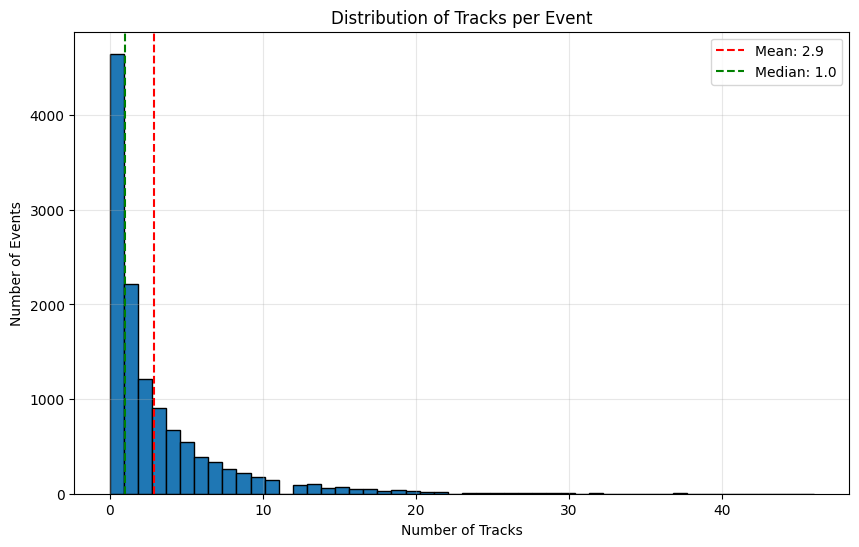

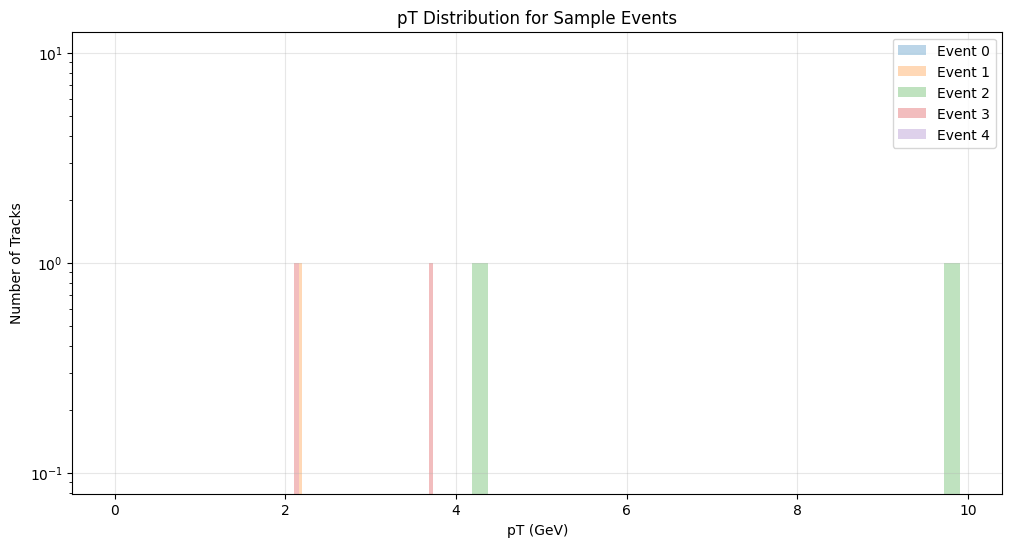

In [8]:
def analyze_event_structure(file_path: str):
    """
    Analyze the structure of tracks within events in ATLAS PHYSLITE data.
    
    Args:
        file_path: Path to ROOT file
    """
    print("\nAnalyzing event structure in:", file_path)
    
    with uproot.open(file_path) as file:
        tree = file["CollectionTree;1"]
        
        # Get arrays for basic track parameters
        pt_branch = "InDetTrackParticlesAuxDyn.qOverP"  # Will convert to pT
        arrays = tree[pt_branch].array(library="np")
        
        # Analyze number of tracks per event
        tracks_per_event = np.array([len(event) for event in arrays])
        
        print("\nTracks per Event Statistics:")
        print(f"Total events: {len(tracks_per_event)}")
        print(f"Total tracks: {sum(tracks_per_event)}")
        print(f"Average tracks/event: {np.mean(tracks_per_event):.2f}")
        print(f"Median tracks/event: {np.median(tracks_per_event):.2f}")
        print(f"Min tracks/event: {np.min(tracks_per_event)}")
        print(f"Max tracks/event: {np.max(tracks_per_event)}")
        
        # Get detailed distribution
        percentiles = [10, 25, 50, 75, 90, 95, 99]
        print("\nTracks per Event Percentiles:")
        for p in percentiles:
            print(f"{p}th percentile: {np.percentile(tracks_per_event, p):.1f}")
        
        # Look at some example events
        print("\nExample Events:")
        for i in range(min(5, len(arrays))):
            event = arrays[i]
            # Convert qOverP to pT
            theta = tree["InDetTrackParticlesAuxDyn.theta"].array(library="np")[i]
            pt = np.abs(1.0 / (event * 1000)) * np.sin(theta)  # Convert to GeV
            
            print(f"\nEvent {i}:")
            print(f"  Number of tracks: {len(event)}")
            if len(event) > 0:
                print(f"  pT range: [{np.min(pt):.2f}, {np.max(pt):.2f}] GeV")
                
        # Visualize distribution
        plt.figure(figsize=(10, 6))
        plt.hist(tracks_per_event, bins=50, edgecolor='black')
        plt.title('Distribution of Tracks per Event')
        plt.xlabel('Number of Tracks')
        plt.ylabel('Number of Events')
        plt.grid(True, alpha=0.3)
        
        # Add mean and median lines
        plt.axvline(np.mean(tracks_per_event), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(tracks_per_event):.1f}')
        plt.axvline(np.median(tracks_per_event), color='g', linestyle='--', 
                   label=f'Median: {np.median(tracks_per_event):.1f}')
        plt.legend()
        plt.show()
        
        # Plot pT distribution for a few events
        plt.figure(figsize=(12, 6))
        for i in range(min(5, len(arrays))):
            event = arrays[i]
            theta = tree["InDetTrackParticlesAuxDyn.theta"].array(library="np")[i]
            pt = np.abs(1.0 / (event * 1000)) * np.sin(theta)
            plt.hist(pt, bins=30, alpha=0.3, label=f'Event {i}')
            
        plt.title('pT Distribution for Sample Events')
        plt.xlabel('pT (GeV)')
        plt.ylabel('Number of Tracks')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Run the analysis

file_path = "atlas_data/catalogs/Run_00296939_catalog_0.root"
analyze_event_structure(file_path)


Processing catalog index 0

Processing catalog index 1

Processing catalog index 2

Processing catalog index 3

Processing catalog index 4

Processing catalog index 5

Processing catalog index 6

Processing catalog index 7

Processing catalog index 8

=== Summary for Run 00296939 ===
Processed 9 catalog files

Event Statistics:
Total events: 735,764

Pile-up Information:
Average interactions per crossing: 16.98
Range: [14.5, 18.9]

Track Collection Statistics:
InDet Tracks:
  Total: 1,670,731
  Average per event: 2.27
Combined Tracks:
  Total: 89,225
  Average per event: 0.12
GSF Tracks:
  Total: 44,308
  Average per event: 0.06
MuonSpec Tracks:
  Total: 251,275
  Average per event: 0.34

Track Quality Statistics:
Average hits per track: 35.17
Average χ²/ndof: 0.93


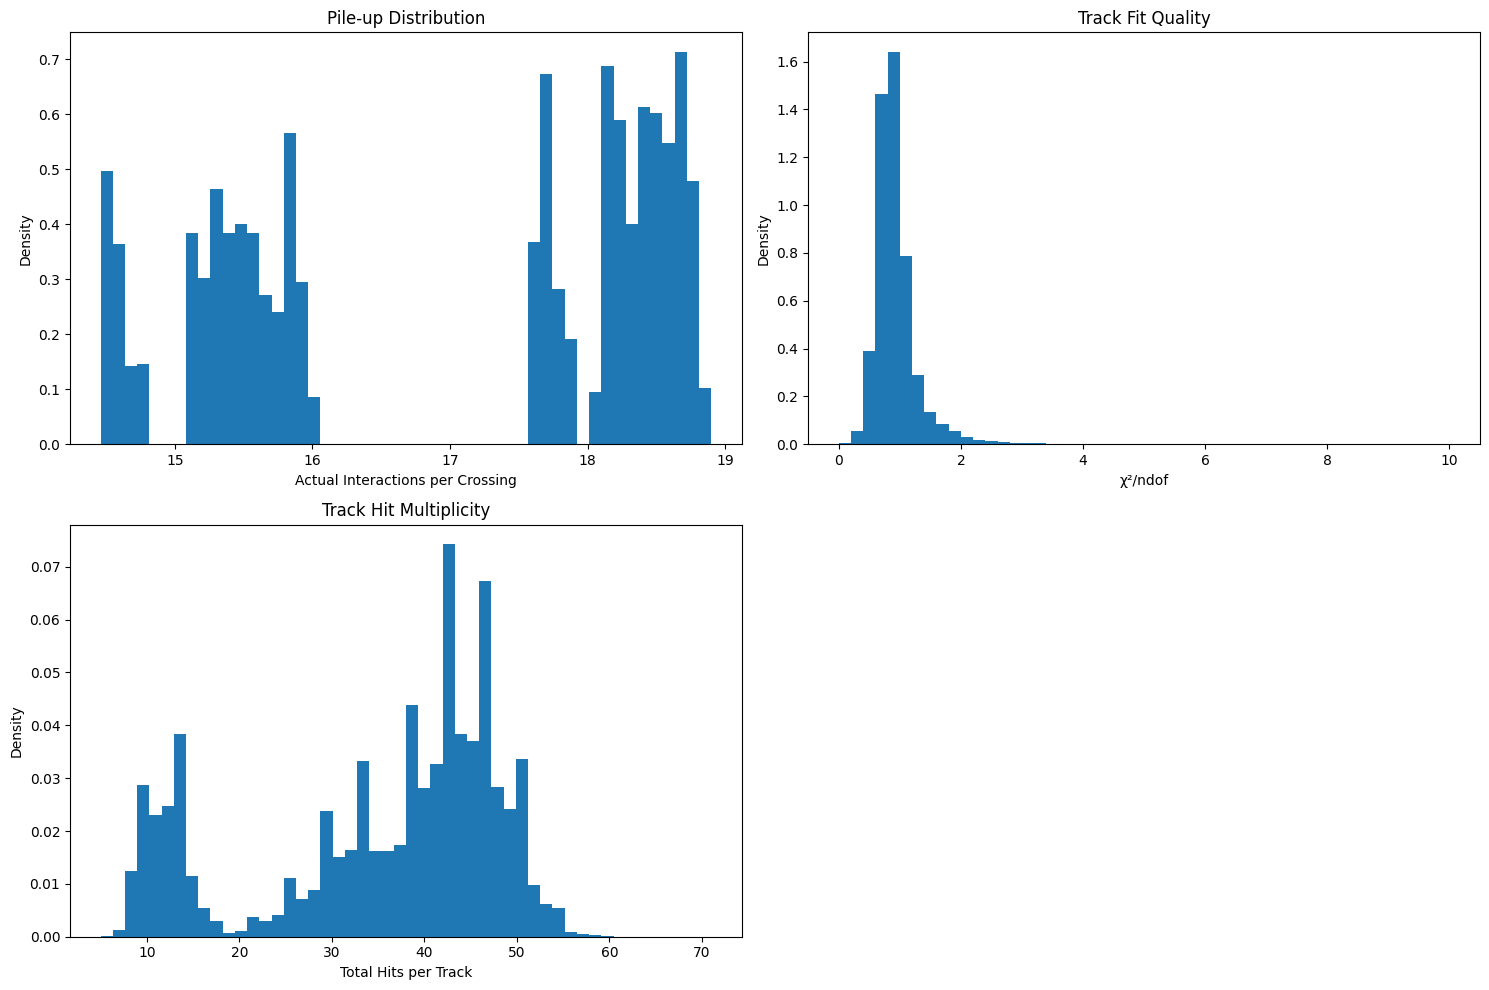

In [12]:
def analyze_run_characteristics(run_number: str, base_dir: str = "atlas_data"):
    """
    Analyze all available catalog files for a given run number
    
    Args:
        run_number: Run number as string (e.g., "00296939")
        base_dir: Base directory containing catalogs
    """
    base_path = Path(base_dir) / "catalogs"
    
    # Aggregate statistics across all files
    total_events = 0
    total_tracks = {
        'InDet': 0,
        'Combined': 0,
        'GSF': 0,
        'MuonSpec': 0
    }
    all_pileup = []
    all_chi2_dof = []
    all_nhits = []
    files_processed = 0
    
    index = 0
    while True:
        catalog_path = base_path / f"Run_{run_number}_catalog_{index}.root"
        
        if not catalog_path.exists():
            if index == 0:
                print(f"No catalog files found for run {run_number}")
            break
            
        print(f"\nProcessing catalog index {index}")
        try:
            with uproot.open(catalog_path) as file:
                tree = file["CollectionTree;1"]
                
                # Get event info
                event_info = {
                    'eventNumber': tree['EventInfoAuxDyn.eventNumber'].array(library="np"),
                    'actualInts': tree['EventInfoAuxDyn.actualInteractionsPerCrossing'].array(library="np"),
                    'avgInts': tree['EventInfoAuxDyn.averageInteractionsPerCrossing'].array(library="np"),
                    'runNumber': tree['EventInfoAuxDyn.runNumber'].array(library="np")
                }
                
                # Track collections
                track_collections = {
                    'InDet': tree['InDetTrackParticlesAuxDyn.phi'].array(library="np"),
                    'Combined': tree['CombinedMuonTrackParticlesAuxDyn.phi'].array(library="np"),
                    'GSF': tree['GSFTrackParticlesAuxDyn.phi'].array(library="np"),
                    'MuonSpec': tree['MuonSpectrometerTrackParticlesAuxDyn.phi'].array(library="np")
                }
                
                # Quality variables
                quality_vars = {
                    'nPixHits': tree['InDetTrackParticlesAuxDyn.numberOfPixelHits'].array(library="np"),
                    'nSCTHits': tree['InDetTrackParticlesAuxDyn.numberOfSCTHits'].array(library="np"),
                    'nTRTHits': tree['InDetTrackParticlesAuxDyn.numberOfTRTHits'].array(library="np"),
                    'chi2': tree['InDetTrackParticlesAuxDyn.chiSquared'].array(library="np"),
                    'ndof': tree['InDetTrackParticlesAuxDyn.numberDoF'].array(library="np")
                }
                
                # Update statistics
                n_events = len(event_info['eventNumber'])
                total_events += n_events
                all_pileup.extend(event_info['actualInts'])
                
                # Track statistics
                for name, tracks in track_collections.items():
                    n_tracks = sum(len(evt_tracks) for evt_tracks in tracks)
                    total_tracks[name] += n_tracks
                
                # Quality statistics
                chi2_per_dof = [
                    chi2/ndof 
                    for evt_chi2, evt_ndof in zip(quality_vars['chi2'], quality_vars['ndof'])
                    for chi2, ndof in zip(evt_chi2, evt_ndof)
                    if ndof > 0
                ]
                all_chi2_dof.extend(chi2_per_dof)
                
                nhits = [
                    pix + sct + trt
                    for evt_pix, evt_sct, evt_trt in zip(
                        quality_vars['nPixHits'],
                        quality_vars['nSCTHits'],
                        quality_vars['nTRTHits']
                    )
                    for pix, sct, trt in zip(evt_pix, evt_sct, evt_trt)
                ]
                all_nhits.extend(nhits)
                
                files_processed += 1
                
        except Exception as e:
            print(f"Error processing catalog {index}: {str(e)}")
            break
            
        index += 1
    
    # Print summary statistics
    if files_processed > 0:
        print(f"\n=== Summary for Run {run_number} ===")
        print(f"Processed {files_processed} catalog files")
        print(f"\nEvent Statistics:")
        print(f"Total events: {total_events:,}")
        print(f"\nPile-up Information:")
        print(f"Average interactions per crossing: {np.mean(all_pileup):.2f}")
        print(f"Range: [{np.min(all_pileup):.1f}, {np.max(all_pileup):.1f}]")
        
        print("\nTrack Collection Statistics:")
        for name, count in total_tracks.items():
            print(f"{name} Tracks:")
            print(f"  Total: {count:,}")
            print(f"  Average per event: {count/total_events:.2f}")
        
        print("\nTrack Quality Statistics:")
        print(f"Average hits per track: {np.mean(all_nhits):.2f}")
        print(f"Average χ²/ndof: {np.mean(all_chi2_dof):.2f}")
        
        # Visualizations
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Tracks per event distributions (normalized)
        plt.subplot(2, 2, 1)
        plt.hist(all_pileup, bins=50, density=True)
        plt.xlabel('Actual Interactions per Crossing')
        plt.ylabel('Density')
        plt.title('Pile-up Distribution')
        
        # Plot 2: Track quality
        plt.subplot(2, 2, 2)
        plt.hist(all_chi2_dof, bins=50, range=(0, 10), density=True)
        plt.xlabel('χ²/ndof')
        plt.ylabel('Density')
        plt.title('Track Fit Quality')
        
        # Plot 3: Number of hits
        plt.subplot(2, 2, 3)
        plt.hist(all_nhits, bins=50, density=True)
        plt.xlabel('Total Hits per Track')
        plt.ylabel('Density')
        plt.title('Track Hit Multiplicity')
        
        plt.tight_layout()
        plt.show()
        
        return {
            'total_events': total_events,
            'total_tracks': total_tracks,
            'pileup_stats': {
                'mean': np.mean(all_pileup),
                'std': np.std(all_pileup),
                'min': np.min(all_pileup),
                'max': np.max(all_pileup)
            },
            'quality_stats': {
                'mean_hits': np.mean(all_nhits),
                'mean_chi2': np.mean(all_chi2_dof)
            }
        }
    
    return None

# Example usage:
run_number = "00296939"
stats = analyze_run_characteristics(run_number)

In [19]:
import json
import numpy as np
from datetime import datetime
from pathlib import Path
import uproot
import gc
from typing import Dict, List

class NumpyJSONEncoder(json.JSONEncoder):
    """Custom JSON encoder for numpy types"""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, datetime):
            return obj.isoformat()
        return super().default(obj)

class RunningStats:
    """Class to compute running statistics without storing all values"""
    def __init__(self):
        self.n = 0
        self.mean = 0.0
        self.M2 = 0.0  # For variance calculation
        self.min_val = float('inf')
        self.max_val = float('-inf')
        
        # For histograms, store counts in bins
        self.hist_bins = np.linspace(0, 100, 101)  # Adjustable
        self.hist_counts = np.zeros(100)
    
    def update(self, value):
        """Update running statistics with new value"""
        value = float(value)  # Convert numpy types to native Python float
        self.n += 1
        delta = value - self.mean
        self.mean += delta / self.n
        delta2 = value - self.mean
        self.M2 += delta * delta2
        
        self.min_val = min(self.min_val, value)
        self.max_val = max(self.max_val, value)
        
        # Update histogram
        bin_idx = np.digitize([value], self.hist_bins)[0] - 1
        if 0 <= bin_idx < len(self.hist_counts):
            self.hist_counts[bin_idx] += 1
    
    def get_stats(self):
        """Get current statistics"""
        variance = self.M2 / (self.n - 1) if self.n > 1 else 0
        return {
            'count': int(self.n),  # Convert to native Python int
            'mean': float(self.mean),  # Convert to native Python float
            'std': float(np.sqrt(variance)),
            'min': float(self.min_val),
            'max': float(self.max_val),
            'histogram': {
                'bins': [float(x) for x in self.hist_bins],  # Convert to native Python floats
                'counts': [int(x) for x in self.hist_counts]  # Convert to native Python ints
            }
        }

class LargeScaleAnalysis:
    def __init__(self, base_dir: str = "atlas_data", output_dir: str = "analysis_output"):
        self.base_dir = Path(base_dir)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Initialize progress tracking
        self.progress_file = self.output_dir / "progress.json"
        self.stats_file = self.output_dir / "run_statistics.json"
        self.load_progress()
    
    def load_progress(self):
        """Load progress from checkpoint file"""
        if self.progress_file.exists():
            with open(self.progress_file, 'r') as f:
                self.progress = json.load(f)
        else:
            self.progress = {
                'completed_runs': [],
                'completed_catalogs': {},
                'last_update': None
            }
    
    def save_progress(self):
        """Save current progress"""
        self.progress['last_update'] = datetime.now().isoformat()
        with open(self.progress_file, 'w') as f:
            json.dump(self.progress, f, indent=2, cls=NumpyJSONEncoder)
    
    def save_run_statistics(self, run_number: str, stats):
        """Save statistics for a run"""
        # Convert RunningStats objects to dictionaries
        stats_dict = {
            'total_events': int(stats['total_events']),  # Convert to native Python int
            'total_tracks': {k: int(v) for k, v in stats['total_tracks'].items()},  # Convert to native Python ints
            'catalogs_processed': int(stats['catalogs_processed']),
            'status': stats['status'],
            'pileup': stats['pileup'].get_stats(),
            'chi2_per_dof': stats['chi2_per_dof'].get_stats(),
            'n_hits': stats['n_hits'].get_stats()
        }
        
        # Load existing stats if file exists
        all_stats = {}
        if self.stats_file.exists():
            try:
                with open(self.stats_file, 'r') as f:
                    all_stats = json.load(f)
            except json.JSONDecodeError:
                print("Warning: Could not read existing stats file, creating new one")
        
        # Update with new stats
        all_stats[run_number] = stats_dict
        
        # Save updated stats using custom encoder
        with open(self.stats_file, 'w') as f:
            json.dump(all_stats, f, indent=2, cls=NumpyJSONEncoder)
    
    def analyze_run(self, run_number: str):
        """Analyze all catalogs for a run with memory-efficient statistics"""
        if run_number in self.progress['completed_runs']:
            print(f"Run {run_number} already processed, skipping...")
            return
        
        stats = {
            'total_events': 0,
            'total_tracks': {name: 0 for name in ['InDet', 'Combined', 'GSF', 'MuonSpec']},
            'pileup': RunningStats(),
            'chi2_per_dof': RunningStats(),
            'n_hits': RunningStats(),
            'catalogs_processed': 0,
            'status': 'incomplete'
        }
        
        index = 0
        while True:
            catalog_path = self.base_dir / "catalogs" / f"Run_{run_number}_catalog_{index}.root"
            
            if not catalog_path.exists():
                break
                
            catalog_id = f"{run_number}_{index}"
            if catalog_id in self.progress['completed_catalogs']:
                print(f"Catalog {catalog_id} already processed, skipping...")
                index += 1
                continue
                
            print(f"\nProcessing catalog {catalog_id}")
            try:
                with uproot.open(catalog_path) as file:
                    self.process_catalog(file, stats)
                
                stats['catalogs_processed'] += 1
                
                # Mark catalog as completed
                self.progress['completed_catalogs'][catalog_id] = {
                    'timestamp': datetime.now().isoformat(),
                    'events': stats['total_events']
                }
                self.save_progress()
                
            except Exception as e:
                print(f"Error processing catalog {catalog_id}: {str(e)}")
                break
            
            # Force garbage collection
            gc.collect()
            index += 1
        
        # Save final run statistics
        stats['status'] = 'complete'
        self.save_run_statistics(run_number, stats)
        
        # Mark run as completed
        if run_number not in self.progress['completed_runs']:
            self.progress['completed_runs'].append(run_number)
        self.save_progress()
    
    def process_catalog(self, file, stats):
        """Process a single catalog file"""
        tree = file["CollectionTree;1"]
        
        # Process event info in chunks
        for arrays in tree.iterate(['EventInfoAuxDyn.actualInteractionsPerCrossing'], 
                                 library="np", step_size=10000):
            pileup = arrays['EventInfoAuxDyn.actualInteractionsPerCrossing']
            for evt_pileup in pileup:
                stats['pileup'].update(evt_pileup)
            stats['total_events'] += len(pileup)
        
        # Process track information
        track_types = {
            'InDet': 'InDetTrackParticlesAuxDyn.phi',
            'Combined': 'CombinedMuonTrackParticlesAuxDyn.phi',
            'GSF': 'GSFTrackParticlesAuxDyn.phi',
            'MuonSpec': 'MuonSpectrometerTrackParticlesAuxDyn.phi'
        }
        
        for name, branch in track_types.items():
            for arrays in tree.iterate([branch], library="np", step_size=10000):
                tracks = arrays[branch]
                n_tracks = sum(len(evt_tracks) for evt_tracks in tracks)
                stats['total_tracks'][name] += n_tracks
        
        # Quality variables (process in chunks)
        quality_branches = [
            'InDetTrackParticlesAuxDyn.chiSquared',
            'InDetTrackParticlesAuxDyn.numberDoF',
            'InDetTrackParticlesAuxDyn.numberOfPixelHits',
            'InDetTrackParticlesAuxDyn.numberOfSCTHits',
            'InDetTrackParticlesAuxDyn.numberOfTRTHits'
        ]
        
        for arrays in tree.iterate(quality_branches, library="np", step_size=10000):
            self.process_quality_vars(arrays, stats)
    
    def process_quality_vars(self, arrays, stats):
        """Process track quality variables"""
        # Update chi2/ndof statistics
        for evt_chi2, evt_ndof in zip(
            arrays['InDetTrackParticlesAuxDyn.chiSquared'],
            arrays['InDetTrackParticlesAuxDyn.numberDoF']
        ):
            for chi2, ndof in zip(evt_chi2, evt_ndof):
                if ndof > 0:
                    stats['chi2_per_dof'].update(chi2/ndof)
        
        # Update hits statistics
        for evt_pix, evt_sct, evt_trt in zip(
            arrays['InDetTrackParticlesAuxDyn.numberOfPixelHits'],
            arrays['InDetTrackParticlesAuxDyn.numberOfSCTHits'],
            arrays['InDetTrackParticlesAuxDyn.numberOfTRTHits']
        ):
            for pix, sct, trt in zip(evt_pix, evt_sct, evt_trt):
                stats['n_hits'].update(pix + sct + trt)

# Add RunningStats class definition here (unchanged)

# Example usage:
run_numbers = ["00296939", "00296942", "00297447", "00297170", "00297041", "00297730", "00298591", "00298595", "00298609", "00298633", "00298687", "00298690", "00298771", "00298773", "00298862", "00298967", "00299055", "00299144", "00299147", "00299184", "00299241", "00299243", "00299278", "00299288", "00299315", "00299340", "00299343", "00299390", "00299584", "00300279", "00300287", "00300345", "00300415", "00300418", "00300487", "00300540", "00300571", "00300600", "00300655", "00300687", "00300784", "00300800", "00300863", "00300908", "00301912", "00301915", "00301918", "00301932", "00301973", "00302053", "00302137", "00302265", "00302269", "00302300", "00302347", "00302380", "00302391", "00302393", "00302737", "00302829", "00302831", "00302872", "00302919", "00302925", "00302956", "00303007", "00303059", "00303079", "00303201", "00303208", "00303264", "00303266", "00303291", "00303304", "00303338", "00303421", "00303499", "00303560", "00303638", "00303726", "00303811", "00303817", "00303819", "00303832", "00303846", "00303892", "00303943", "00304006", "00304008", "00304128", "00304178", "00304198", "00304211", "00304243", "00304308", "00304337", "00304409", "00304431", "00304494", "00305291", "00305293", "00305359", "00305380", "00305543", "00305571", "00305618", "00305671", "00305674", "00305723", "00305727", "00305735", "00305777", "00305811", "00305920", "00306247", "00306269", "00306278", "00306310", "00306384", "00306419", "00306442", "00306448", "00306451", "00306556", "00306655", "00306657", "00306714", "00307124", "00307126", "00307195", "00307259", "00307306", "00307354", "00307358", "00307394", "00307454", "00307514", "00307539", "00307569", "00307601", "00307619", "00307656", "00307710", "00307716", "00307732", "00307861", "00307935", "00308047", "00308084", "00309311", "00309314", "00309346", "00309375", "00309390", "00309440", "00309516", "00309640", "00309674", "00309759", "00310015", "00310210", "00310247", "00310249", "00310341", "00310370", "00310405", "00310468", "00310473", "00310574", "00310634", "00310691", "00310738", "00310781", "00310809", "00310863", "00310872", "00310969", "00311071", "00311170", "00311244", "00311287", "00311321", "00311365", "00311402", "00311473", "00311481"]
# run_numbers = run_numbers[:5]  # Limit to first few runs for testing

analyzer = LargeScaleAnalysis()
for run in run_numbers:
    analyzer.analyze_run(run)

Run 00296939 already processed, skipping...
Run 00296942 already processed, skipping...
Run 00297447 already processed, skipping...
Run 00297170 already processed, skipping...
Run 00297041 already processed, skipping...


Analyzing statistics from 5 runs


/lscratch/alexyue/tmp/ipykernel_3613616/1197018225.py:20: RuntimeWarning: invalid value encountered in divide
  counts = np.array(counts) / sum(counts)
/lscratch/alexyue/tmp/ipykernel_3613616/1197018225.py:33: RuntimeWarning: invalid value encountered in divide
  counts = np.array(counts) / sum(counts)
/lscratch/alexyue/tmp/ipykernel_3613616/1197018225.py:47: RuntimeWarning: invalid value encountered in divide
  counts = np.array(counts) / sum(counts)


ZeroDivisionError: division by zero

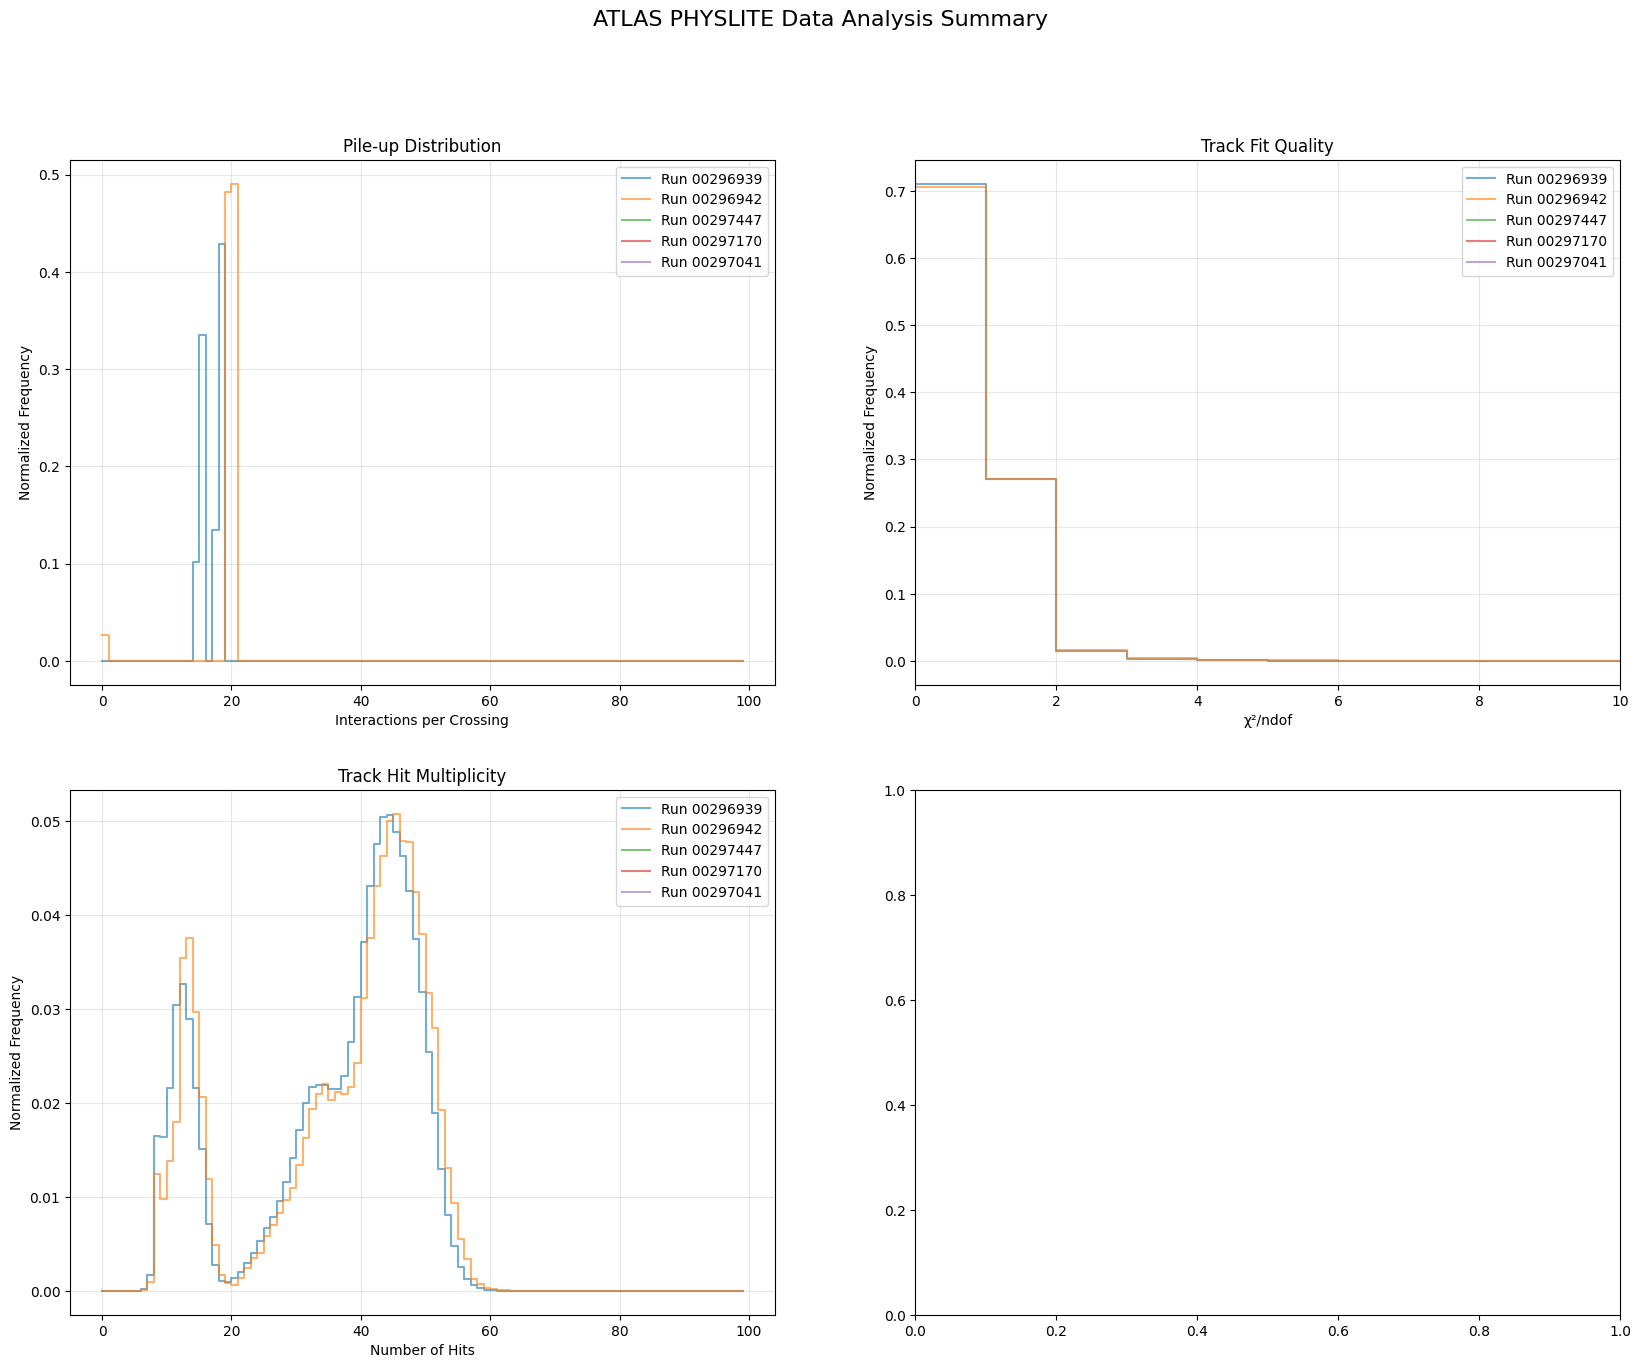

In [20]:
def plot_run_statistics(stats_file: str = "analysis_output/run_statistics.json"):
    """
    Plot histograms and statistics from analyzed runs
    """
    with open(stats_file, 'r') as f:
        all_stats = json.load(f)
    
    print(f"Analyzing statistics from {len(all_stats)} runs")
    
    # Create subplots for different metrics
    fig = plt.figure(figsize=(20, 15))
    plt.suptitle("ATLAS PHYSLITE Data Analysis Summary", fontsize=16)
    
    # 1. Pile-up Distribution
    ax1 = plt.subplot(2, 2, 1)
    for run, stats in all_stats.items():
        bins = stats['pileup']['histogram']['bins']
        counts = stats['pileup']['histogram']['counts']
        # Normalize the histogram
        counts = np.array(counts) / sum(counts)
        ax1.step(bins[:-1], counts, label=f"Run {run}", where='post', alpha=0.6)
    ax1.set_xlabel('Interactions per Crossing')
    ax1.set_ylabel('Normalized Frequency')
    ax1.set_title('Pile-up Distribution')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. Track Quality (χ²/ndof)
    ax2 = plt.subplot(2, 2, 2)
    for run, stats in all_stats.items():
        bins = stats['chi2_per_dof']['histogram']['bins']
        counts = stats['chi2_per_dof']['histogram']['counts']
        counts = np.array(counts) / sum(counts)
        ax2.step(bins[:-1], counts, label=f"Run {run}", where='post', alpha=0.6)
    ax2.set_xlabel('χ²/ndof')
    ax2.set_ylabel('Normalized Frequency')
    ax2.set_title('Track Fit Quality')
    ax2.set_xlim(0, 10)  # Focus on most relevant range
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. Number of Hits per Track
    ax3 = plt.subplot(2, 2, 3)
    for run, stats in all_stats.items():
        bins = stats['n_hits']['histogram']['bins']
        counts = stats['n_hits']['histogram']['counts']
        counts = np.array(counts) / sum(counts)
        ax3.step(bins[:-1], counts, label=f"Run {run}", where='post', alpha=0.6)
    ax3.set_xlabel('Number of Hits')
    ax3.set_ylabel('Normalized Frequency')
    ax3.set_title('Track Hit Multiplicity')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Track Type Distribution
    ax4 = plt.subplot(2, 2, 4)
    track_types = []
    track_counts = []
    run_labels = []
    
    for run, stats in all_stats.items():
        for track_type, count in stats['total_tracks'].items():
            track_types.append(track_type)
            track_counts.append(count / stats['total_events'])  # Normalize by number of events
            run_labels.append(f"Run {run}")
    
    # Create grouped bar chart
    unique_types = sorted(set(track_types))
    unique_runs = sorted(set(run_labels))
    x = np.arange(len(unique_types))
    width = 0.8 / len(unique_runs)
    
    for i, run in enumerate(unique_runs):
        counts = [next((c for t, c, r in zip(track_types, track_counts, run_labels) 
                       if t == type_name and r == run), 0)
                 for type_name in unique_types]
        ax4.bar(x + i*width - 0.4, counts, width, label=run, alpha=0.7)
    
    ax4.set_xticks(x)
    ax4.set_xticklabels(unique_types)
    ax4.set_ylabel('Average Tracks per Event')
    ax4.set_title('Track Type Distribution')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    for run, stats in all_stats.items():
        print(f"\nRun {run}:")
        print(f"Total Events: {stats['total_events']:,}")
        print(f"Catalogs Processed: {stats['catalogs_processed']}")
        print("\nTrack Counts:")
        for track_type, count in stats['total_tracks'].items():
            print(f"  {track_type}: {count:,} ({count/stats['total_events']:.2f} per event)")
        print("\nPile-up:")
        print(f"  Mean: {stats['pileup']['mean']:.2f}")
        print(f"  Std Dev: {stats['pileup']['std']:.2f}")
        print("\nTrack Quality:")
        print(f"  Mean χ²/ndof: {stats['chi2_per_dof']['mean']:.2f}")
        print(f"  Mean hits/track: {stats['n_hits']['mean']:.2f}")
    
    return fig

# Plot the statistics
fig = plot_run_statistics()
plt.show()


Analyzing Run 00296939

Analyzing Run 00296942

Analyzing Run 00297447
Catalog not found for run 00297447

Analyzing Run 00297170
Catalog not found for run 00297170

Analyzing Run 00297041
Catalog not found for run 00297041

Analyzing Run 00297730
Catalog not found for run 00297730

Analyzing Run 00298591
Catalog not found for run 00298591

Analyzing Run 00298595
Catalog not found for run 00298595

Analyzing Run 00298609
Catalog not found for run 00298609

Analyzing Run 00298633
Catalog not found for run 00298633

Analyzing Run 00298687
Catalog not found for run 00298687

Analyzing Run 00298690
Catalog not found for run 00298690

Analyzing Run 00298771
Catalog not found for run 00298771

Analyzing Run 00298773
Catalog not found for run 00298773

Analyzing Run 00298862
Catalog not found for run 00298862

Analyzing Run 00298967
Catalog not found for run 00298967

Analyzing Run 00299055
Catalog not found for run 00299055

Analyzing Run 00299144
Catalog not found for run 00299144

Analyzi

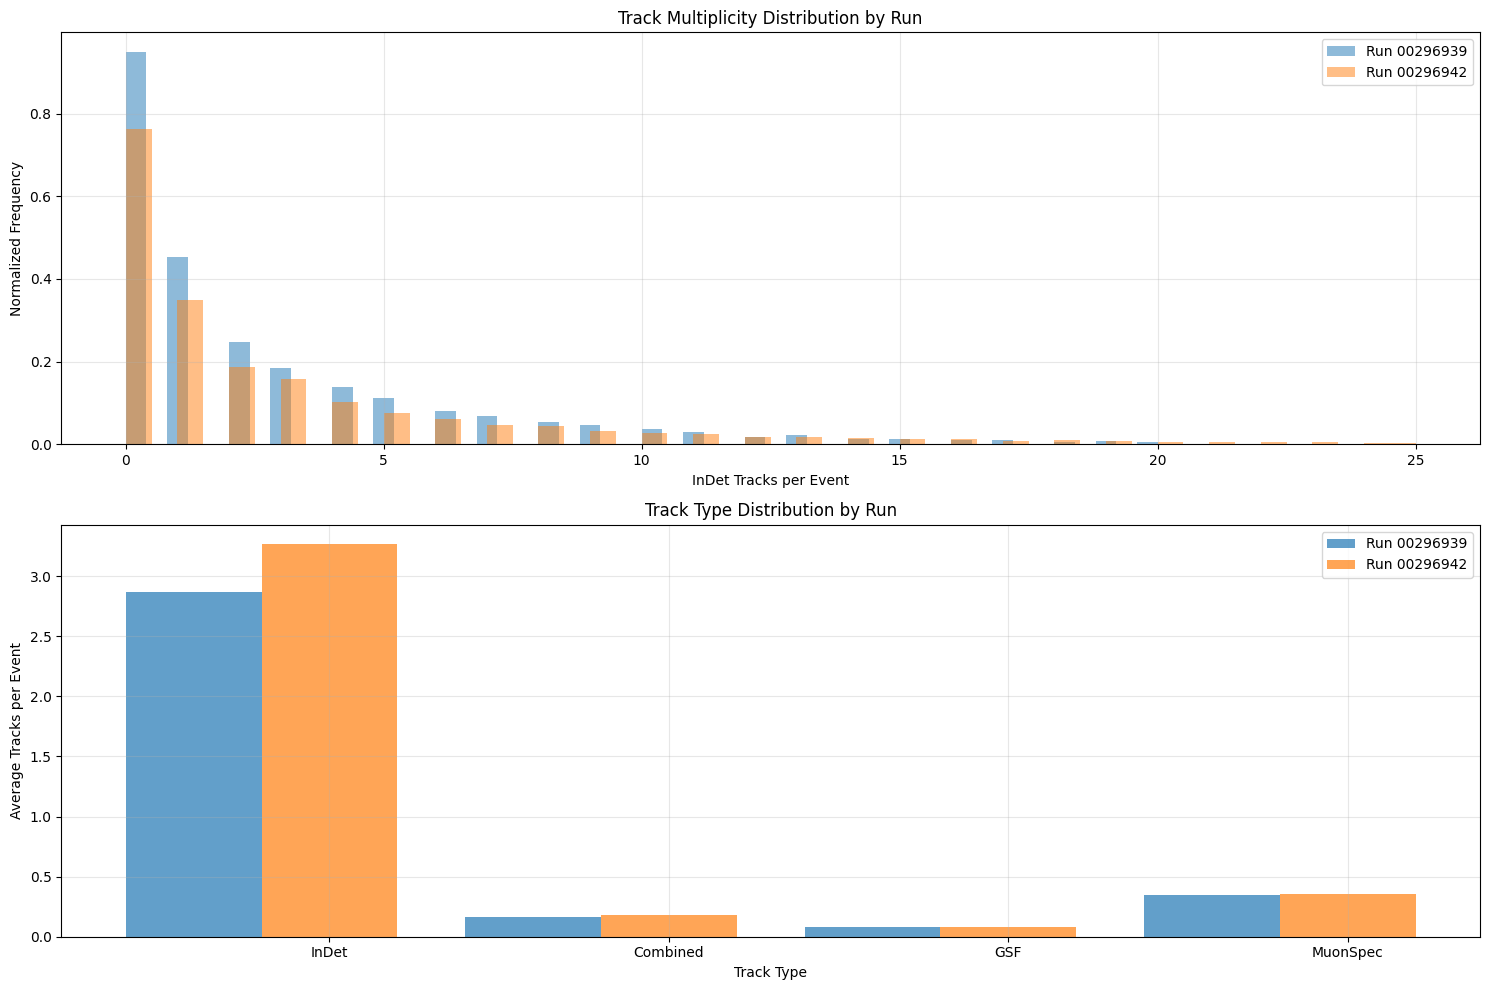

In [21]:
def download_catalog(run_number: str, base_dir: str = "atlas_data") -> Optional[Path]:
    """Download catalog_0 for a run and return its path"""
    base_dir = Path(base_dir)
    catalog_dir = base_dir / "catalogs"
    catalog_dir.mkdir(exist_ok=True)
    
    catalog_path = catalog_dir / f"Run_{run_number}_catalog_0.root"
    url = f"/record/80001/files/data16_13TeV_Run_{run_number}_file_index.json_0"
    
    print(f"Downloading catalog for run {run_number}...")
    try:
        response = requests.get(f"https://opendata.cern.ch{url}", stream=True)
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            
            with open(catalog_path, 'wb') as f, tqdm(
                desc=f"Run {run_number}",
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as pbar:
                for data in response.iter_content(chunk_size=1024):
                    size = f.write(data)
                    pbar.update(size)
            return catalog_path
        else:
            print(f"Failed to download catalog for run {run_number}: Status {response.status_code}")
            return None
    except Exception as e:
        print(f"Error downloading catalog for run {run_number}: {str(e)}")
        return None

def analyze_first_catalogs(run_numbers: List[str], base_dir: str = "atlas_data"):
    """Analyze the first catalog from each run with download and cleanup"""
    results = {}
    
    for run in run_numbers:
        print(f"\nProcessing Run {run}")
        
        # Download catalog
        catalog_path = download_catalog(run, base_dir)
        if catalog_path is None:
            print(f"Skipping run {run} due to download failure")
            continue
        
        try:
            with uproot.open(catalog_path) as file:
                tree = file["CollectionTree;1"]
                
                # Get event info
                event_info = {
                    'eventNumber': tree['EventInfoAuxDyn.eventNumber'].array(library="np"),
                    'actualInts': tree['EventInfoAuxDyn.actualInteractionsPerCrossing'].array(library="np"),
                    'avgInts': tree['EventInfoAuxDyn.averageInteractionsPerCrossing'].array(library="np")
                }
                
                # Get track collections
                track_collections = {
                    'InDet': tree['InDetTrackParticlesAuxDyn.phi'].array(library="np"),
                    'Combined': tree['CombinedMuonTrackParticlesAuxDyn.phi'].array(library="np"),
                    'GSF': tree['GSFTrackParticlesAuxDyn.phi'].array(library="np"),
                    'MuonSpec': tree['MuonSpectrometerTrackParticlesAuxDyn.phi'].array(library="np")
                }
                
                # Compute statistics
                n_events = len(event_info['eventNumber'])
                
                track_stats = {}
                for name, tracks in track_collections.items():
                    n_tracks = [len(evt_tracks) for evt_tracks in tracks]
                    track_stats[name] = {
                        'total': sum(n_tracks),
                        'mean': float(np.mean(n_tracks)),  # Convert to native Python types
                        'median': float(np.median(n_tracks)),
                        'std': float(np.std(n_tracks)),
                        'zeros': int(sum(1 for n in n_tracks if n == 0)),
                        'max': int(max(n_tracks)),
                        'distribution': n_tracks
                    }
                
                results[run] = {
                    'n_events': int(n_events),
                    'mean_pileup': float(np.mean(event_info['actualInts'])),
                    'track_stats': track_stats
                }
                
        except Exception as e:
            print(f"Error analyzing run {run}: {str(e)}")
        finally:
            # Clean up downloaded file
            if catalog_path and catalog_path.exists():
                catalog_path.unlink()
                print(f"Cleaned up catalog for run {run}")
        
        # Save progress after each run
        with open('track_analysis_results.json', 'w') as f:
            # Save everything except the distributions which can be large
            save_results = {
                run: {
                    **data,
                    'track_stats': {
                        name: {k: v for k, v in stats.items() if k != 'distribution'}
                        for name, stats in data['track_stats'].items()
                    }
                }
                for run, data in results.items()
            }
            json.dump(save_results, f, indent=2)
    
    # Create visualization
    plt.figure(figsize=(15, 10))
    
    # 1. Track multiplicity distributions
    plt.subplot(2, 1, 1)
    for run, data in results.items():
        indet_tracks = data['track_stats']['InDet']['distribution']
        plt.hist(indet_tracks, bins=50, alpha=0.5, label=f"Run {run}", 
                range=(0, np.percentile(indet_tracks, 99)),  # Exclude outliers
                density=True)
    plt.xlabel('InDet Tracks per Event')
    plt.ylabel('Normalized Frequency')
    plt.title('Track Multiplicity Distribution by Run')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Track type comparison
    plt.subplot(2, 1, 2)
    track_types = ['InDet', 'Combined', 'GSF', 'MuonSpec']
    x = np.arange(len(track_types))
    width = 0.8 / len(results)
    
    for i, (run, data) in enumerate(results.items()):
        means = [data['track_stats'][tt]['mean'] for tt in track_types]
        plt.bar(x + i*width - width*len(results)/2, means, width, 
               label=f"Run {run}", alpha=0.7)
    
    plt.xlabel('Track Type')
    plt.ylabel('Average Tracks per Event')
    plt.title('Track Type Distribution by Run')
    plt.xticks(x, track_types)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('track_analysis_plots.png')
    plt.close()
    
    # Print summary
    print("\n=== Track Multiplicity Summary ===")
    print(f"Analyzed {len(results)} runs")
    
    for run, data in results.items():
        print(f"\nRun {run}:")
        print(f"Events: {data['n_events']:,}")
        print(f"Average pile-up: {data['mean_pileup']:.2f}")
        print("\nTrack statistics:")
        for track_type, stats in data['track_stats'].items():
            print(f"\n{track_type} Tracks:")
            print(f"  Total: {stats['total']:,}")
            print(f"  Mean per event: {stats['mean']:.2f} ± {stats['std']:.2f}")
            print(f"  Median per event: {stats['median']:.1f}")
            print(f"  Events with no tracks: {stats['zeros']:,} ({stats['zeros']/data['n_events']*100:.1f}%)")
            print(f"  Max tracks in an event: {stats['max']}")
    
    return results

# List of all run numbers
run_numbers = ["00296939", "00296942", "00297447", "00297170", "00297041", "00297730", "00298591", "00298595", "00298609", "00298633", "00298687", "00298690", "00298771", "00298773", "00298862", "00298967", "00299055", "00299144", "00299147", "00299184", "00299241", "00299243", "00299278", "00299288", "00299315", "00299340", "00299343", "00299390", "00299584", "00300279", "00300287", "00300345", "00300415", "00300418", "00300487", "00300540", "00300571", "00300600", "00300655", "00300687", "00300784", "00300800", "00300863", "00300908", "00301912", "00301915", "00301918", "00301932", "00301973", "00302053", "00302137", "00302265", "00302269", "00302300", "00302347", "00302380", "00302391", "00302393", "00302737", "00302829", "00302831", "00302872", "00302919", "00302925", "00302956", "00303007", "00303059", "00303079", "00303201", "00303208", "00303264", "00303266", "00303291", "00303304", "00303338", "00303421", "00303499", "00303560", "00303638", "00303726", "00303811", "00303817", "00303819", "00303832", "00303846", "00303892", "00303943", "00304006", "00304008", "00304128", "00304178", "00304198", "00304211", "00304243", "00304308", "00304337", "00304409", "00304431", "00304494", "00305291", "00305293", "00305359", "00305380", "00305543", "00305571", "00305618", "00305671", "00305674", "00305723", "00305727", "00305735", "00305777", "00305811", "00305920", "00306247", "00306269", "00306278", "00306310", "00306384", "00306419", "00306442", "00306448", "00306451", "00306556", "00306655", "00306657", "00306714", "00307124", "00307126", "00307195", "00307259", "00307306", "00307354", "00307358", "00307394", "00307454", "00307514", "00307539", "00307569", "00307601", "00307619", "00307656", "00307710", "00307716", "00307732", "00307861", "00307935", "00308047", "00308084", "00309311", "00309314", "00309346", "00309375", "00309390", "00309440", "00309516", "00309640", "00309674", "00309759", "00310015", "00310210", "00310247", "00310249", "00310341", "00310370", "00310405", "00310468", "00310473", "00310574", "00310634", "00310691", "00310738", "00310781", "00310809", "00310863", "00310872", "00310969", "00311071", "00311170", "00311244", "00311287", "00311321", "00311365", "00311402", "00311473", "00311481"]


# Analyze with download and cleanup
results = analyze_first_catalogs(run_numbers)